In [88]:
!pip install SimpleITK

In [89]:
pip install nibabel scikit-image


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [90]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# Load and preprocessing the data in batches
def load_data(file_path, target_shape):
    # Load NIfTI file using nibabel
    img = nib.load(file_path)
    data = img.get_fdata()

    # Resize the data to the target shape
    resized_data = resize(data, target_shape)

    return resized_data

def load_and_preprocess_data(file_paths, target_shape=(256, 256, 1)):
    data_list = []
    for file_path in file_paths:
        data = load_data(file_path, target_shape)
        data_list.append(data)

    data_array = np.stack(data_list, axis=0)
    return data_array

# Batch size for loading and preprocessing
batch_size = 2

# Defining target shape
target_shape = (256, 256, 1)

# Dataset paths
input_folder = '/content/drive/MyDrive/Dataset/Liver_tumor Part2'
input_files = [os.path.join(input_folder, f'volume-{i}.nii') for i in range(51, 56)]

segmentation_folder = '/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations'
segmentation_files = [os.path.join(segmentation_folder, f'segmentation-{i}.nii') for i in [0, 1, 10, 11, 12]]



# Displaying input and segmentation file names with directory names
def display_file_names(input_files, segmentation_files):
    print("Input Files:")
    for file_path in input_files:
        directory_name, file_name = os.path.split(file_path)
        print(f"Directory: {directory_name}, File: {file_name}")

    print("\nSegmentation Files:")
    for file_path in segmentation_files:
        directory_name, file_name = os.path.split(file_path)
        print(f"Directory: {directory_name}, File: {file_name}")

# Example usage:
display_file_names(input_files, segmentation_files)





# Loading and preprocessing segmentation data in batches
segmentation_data = []
for i in range(0, len(segmentation_files), batch_size):
    batch_files = segmentation_files[i:i + batch_size]
    batch_data = load_and_preprocess_data(batch_files, target_shape)
    batch_data[batch_data > 0] = 1
    segmentation_data.append(batch_data)

segmentation_data = np.vstack(segmentation_data)

# Loading and preprocessing input data in batches
input_data = []
for i in range(0, len(input_files), batch_size):
    batch_files = input_files[i:i + batch_size]
    batch_data = load_and_preprocess_data(batch_files, target_shape)
    batch_data = (batch_data - np.min(batch_data)) / (np.max(batch_data) - np.min(batch_data))
    input_data.append(batch_data)

input_data = np.vstack(input_data)

# UNet model architecture
def unet_model(input_size):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(drop4)

    # Middle
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = concatenate([up6, drop4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model



Input Files:
Directory: /content/drive/MyDrive/Dataset/Liver_tumor Part2, File: volume-51.nii
Directory: /content/drive/MyDrive/Dataset/Liver_tumor Part2, File: volume-52.nii
Directory: /content/drive/MyDrive/Dataset/Liver_tumor Part2, File: volume-53.nii
Directory: /content/drive/MyDrive/Dataset/Liver_tumor Part2, File: volume-54.nii
Directory: /content/drive/MyDrive/Dataset/Liver_tumor Part2, File: volume-55.nii

Segmentation Files:
Directory: /content/drive/MyDrive/Dataset/Liver  Part 1/segmentations, File: segmentation-0.nii
Directory: /content/drive/MyDrive/Dataset/Liver  Part 1/segmentations, File: segmentation-1.nii
Directory: /content/drive/MyDrive/Dataset/Liver  Part 1/segmentations, File: segmentation-10.nii
Directory: /content/drive/MyDrive/Dataset/Liver  Part 1/segmentations, File: segmentation-11.nii
Directory: /content/drive/MyDrive/Dataset/Liver  Part 1/segmentations, File: segmentation-12.nii


In [91]:
# Training the model
model = unet_model((256, 256, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(input_data, segmentation_data, epochs=5, batch_size=1, validation_split=0.2)


Epoch 1/5
4/4 [==============================] - 6s 225ms/step - loss: 194.1789 - accuracy: 0.6903 - val_loss: 0.6725 - val_accuracy: 0.7496
Epoch 2/5
4/4 [==============================] - 0s 127ms/step - loss: 0.6656 - accuracy: 0.8176 - val_loss: 0.6693 - val_accuracy: 0.7496
Epoch 3/5
4/4 [==============================] - 0s 113ms/step - loss: 0.6181 - accuracy: 0.8176 - val_loss: 0.6263 - val_accuracy: 0.7496
Epoch 4/5
4/4 [==============================] - 0s 127ms/step - loss: 0.5676 - accuracy: 0.8176 - val_loss: 0.6125 - val_accuracy: 0.7496
Epoch 5/5
4/4 [==============================] - 0s 129ms/step - loss: 0.5475 - accuracy: 0.8176 - val_loss: 0.6932 - val_accuracy: 0.7496


In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


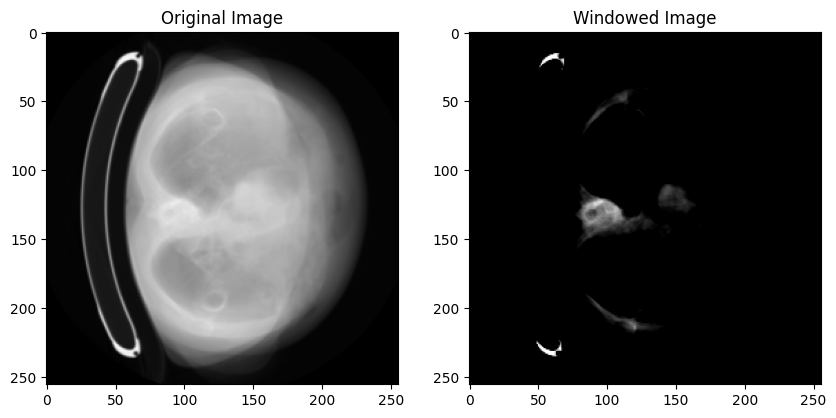

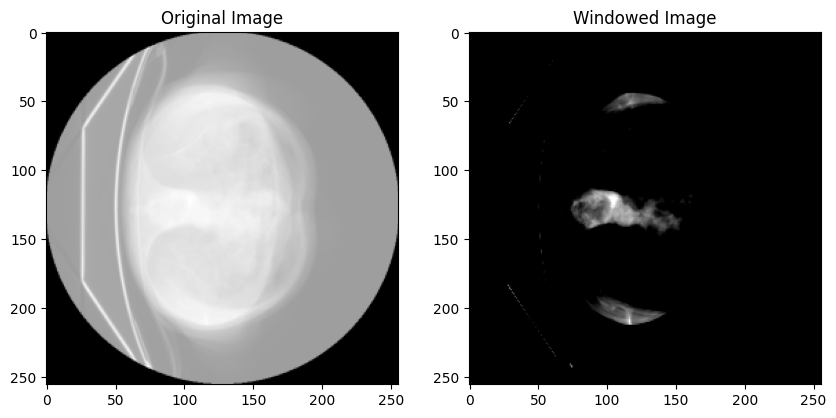

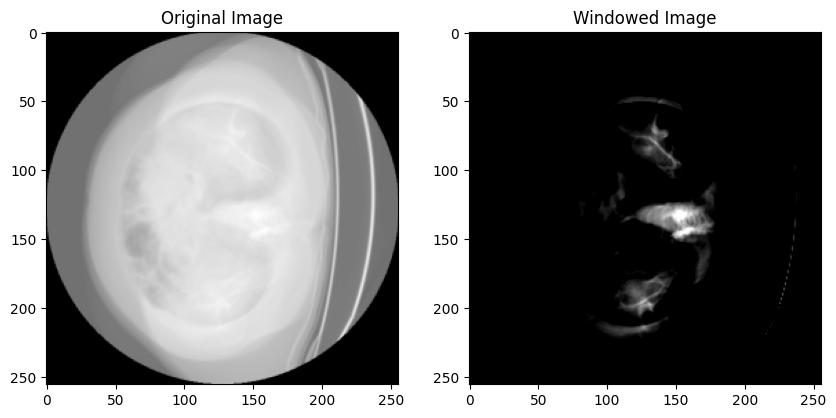

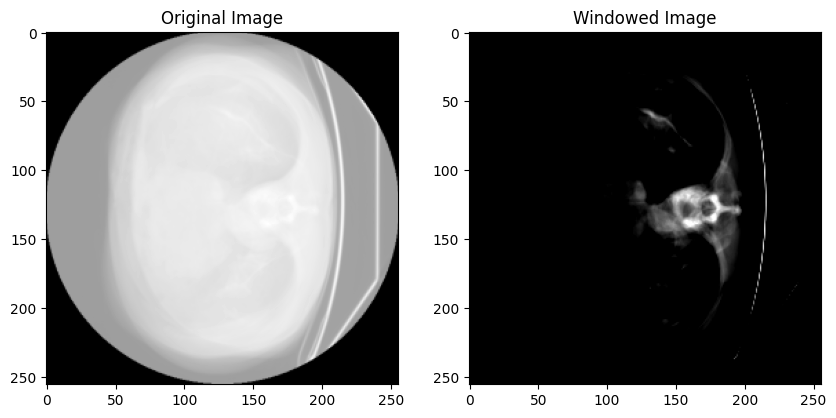

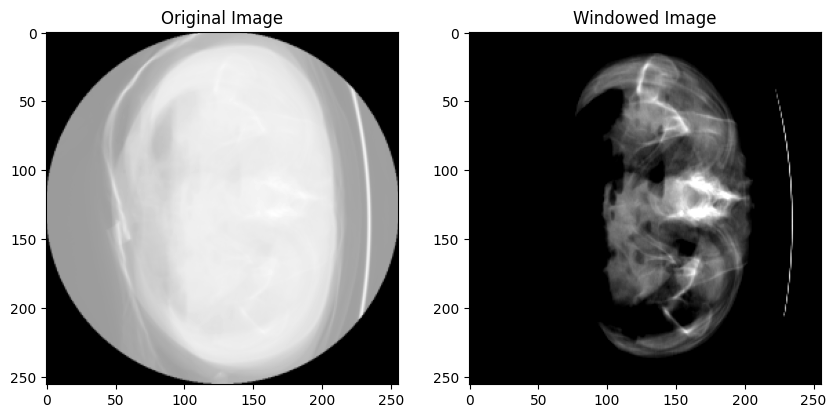

In [93]:
def apply_window(image, center, width):
    windowed_image = np.clip((image - (center - 0.5 * width)) / width, 0, 1)
    return windowed_image

# Function to generate and display windowed images
def generate_and_display_windowed_images(input_files, center, width):
    for file_path in input_files:
        input_data = load_data(file_path, target_shape=(256, 256, 1))

        # Apply windowing to the input data
        windowed_image = apply_window(input_data, center, width)

        # Display original and windowed images side by side
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(np.squeeze(input_data), cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title("Windowed Image")
        plt.imshow(np.squeeze(windowed_image), cmap="gray")

        plt.show()


window_center = 100
window_width = 200
generate_and_display_windowed_images(input_files, window_center, window_width)

In [94]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 256, 256, 64)         640       ['input_4[0][0]']             
                                                                                                  
 conv2d_58 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_57[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_58[0][0]']           
 ng2D)                                                                                      

In [95]:
print(input_data.shape)

(5, 256, 256, 1)


1/1 [==============================] - 0s 198ms/step


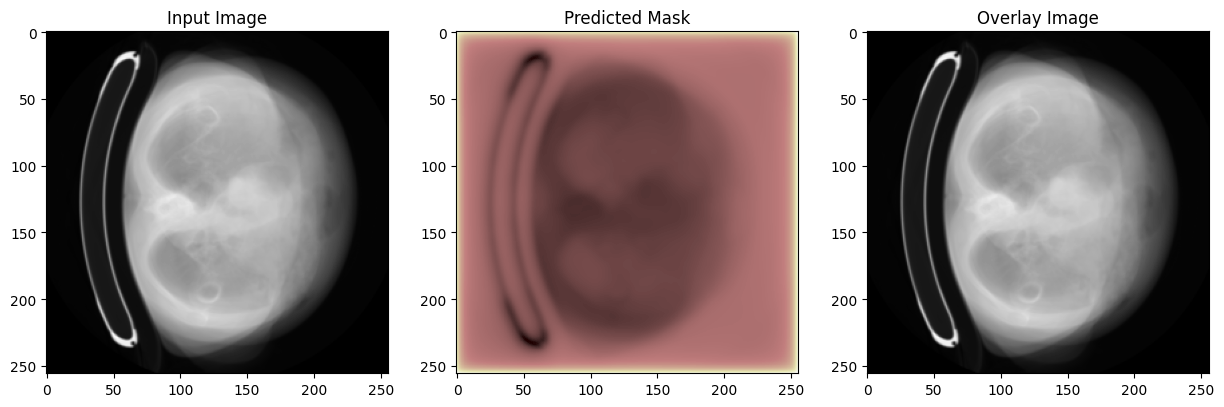

1/1 [==============================] - 0s 21ms/step


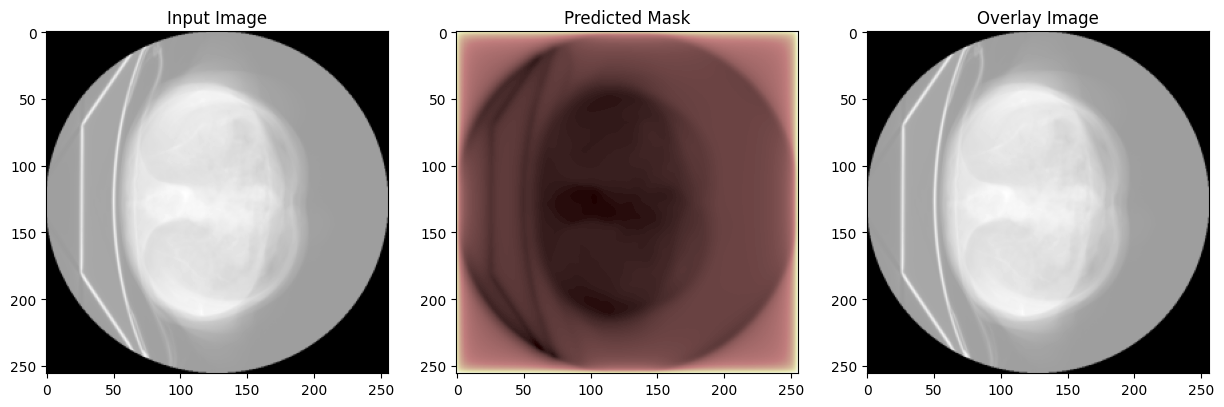

1/1 [==============================] - 0s 26ms/step


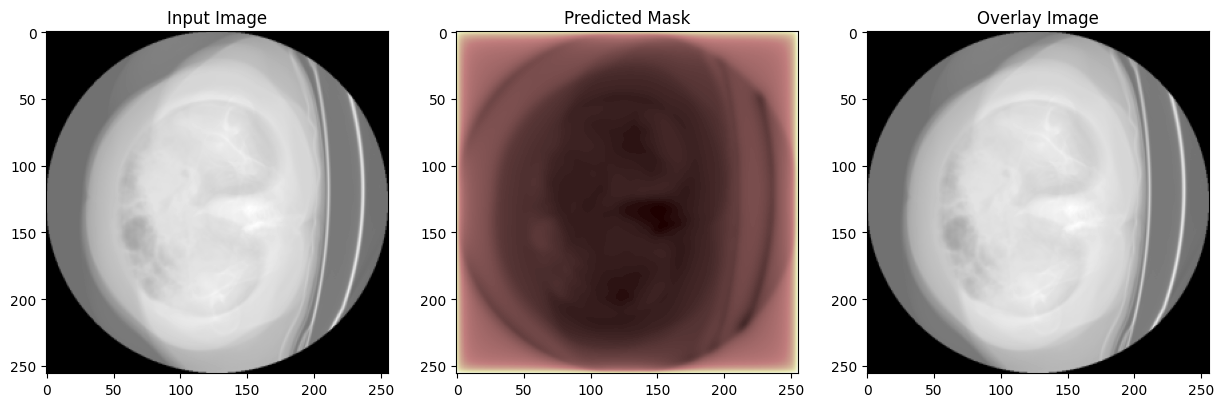

1/1 [==============================] - 0s 19ms/step


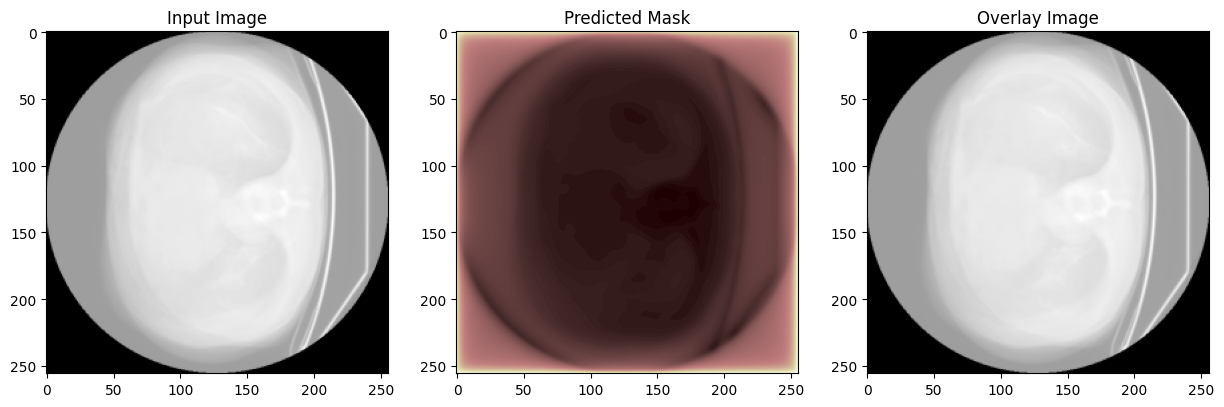

1/1 [==============================] - 0s 21ms/step


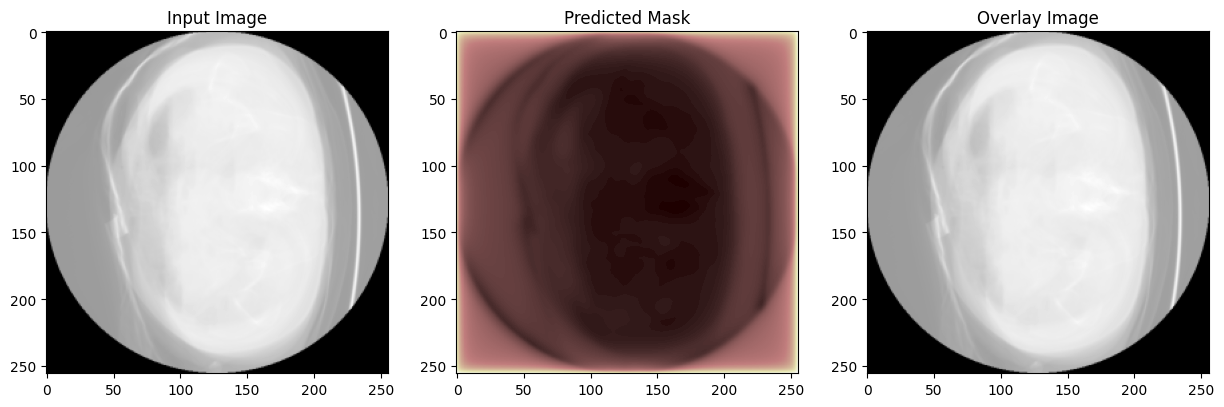

In [96]:
import matplotlib.pyplot as plt

# Generating predicted images
def generate_and_show_maxpool_images(model, input_files, threshold=0.5):
    for file_path in input_files:
        input_data = load_data(file_path, target_shape=(256, 256, 1))

        # Normalize the input_data
        input_data_min = np.min(input_data)
        input_data_max = np.max(input_data)
        input_data = (input_data - input_data_min) / (input_data_max - input_data_min)

        input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension

        # Predicting segmentation mask
        predicted_mask = model.predict(input_data)

        # Apply threshold to the predicted mask
        binary_mask = (predicted_mask > threshold).astype(np.uint8)

        # Creating overlay image
        overlay_image = input_data.copy()
        overlay_image[binary_mask == 1] = 1.0  # Set pixels in the tumor region to a different intensity (e.g., white)

        # Displaying input, predicted mask, and overlay images
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(np.squeeze(input_data), cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title("Predicted Mask")
        plt.imshow(np.squeeze(predicted_mask), cmap="pink")

        plt.subplot(1, 3, 3)
        plt.title("Overlay Image")
        plt.imshow(np.squeeze(overlay_image), cmap="gray")

        plt.show()

# Example usage:
generate_and_show_maxpool_images(model, input_files)


In [97]:

test_input_files = ['/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-0.nii'
                    ,'/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-1.nii'
                    ,'/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-11.nii'
                    ,'/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-11.nii'
                    ,'/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-12.nii']

  # List of file paths for test input data
test_segmentation_files = ['/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-0.nii'
                    ,'/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-0.nii'
                    ,'/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-10.nii'
                    ,'/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-11.nii'
                    ,'/content/drive/MyDrive/Dataset/Liver  Part 1/segmentations/segmentation-12.nii']  # List of file paths for test segmentation data

# Loading and preprocessing test data
test_input_data = load_and_preprocess_data(test_input_files, target_shape)
test_segmentation_data = load_and_preprocess_data(test_segmentation_files, target_shape)
test_segmentation_data[test_segmentation_data > 0] = 1  # Applying threshold

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_input_data, test_segmentation_data)

# Make predictions on the test set
y_pred = model.predict(test_input_data)
y_pred_classes = (y_pred > 0.5).astype(np.uint8)

# Convert one-hot encoded labels to integers
y_true_classes = test_segmentation_data.astype(np.uint8)

# Print classification report
print("Classification Report:\n", classification_report(y_true_classes.flatten(), y_pred_classes.flatten()))

# Print accuracy
print("Test Accuracy:", test_accuracy)





1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89    265297
           1       0.00      0.00      0.00     62383

    accuracy                           0.81    327680
   macro avg       0.40      0.50      0.45    327680
weighted avg       0.66      0.81      0.72    327680

Test Accuracy: 0.8096221685409546


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


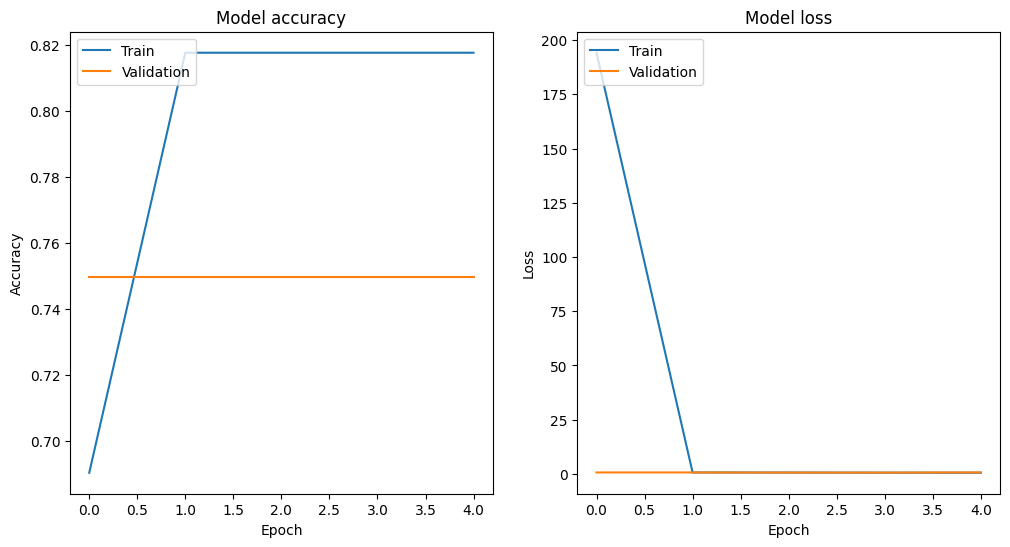

In [98]:
# Assuming you have a training history object named 'history' obtained from model.fit()

# Plot training accuracy and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()
